# Customer Churn Prediction at Vodafone

## `Business Understanding`
Vodafone is a global telecommunications company operating in numerous countries, providing mobile and fixed-line telecommunication services to millions of customers worldwide.

`Problem statement:` Vodafone faces tough competition and wants to know how likely customers are to leave and why. Keeping customers despite churn needs smart strategies. Vodafone aims to keep its current customers happy and attract new ones in this competitive market by understanding these challenges.

`Goal:` The primary goal of this project is to develop a machine learning model capable of predicting the likelihood of customer churn within Vodafone's customer base. Additionally, the project aims to identify key indicators of customer churn and devise effective retention strategies to reduce the rate of customers leaving. By leveraging data-driven insights, this project seeks to enhance customer retention rates.

### `Hypothesis`
`Null:` There is no significant difference in churn rates and different contract types

`Alternative:` There is significant difference in churn rates and different contract types

### `Research Questions`
- What payment methods do customers use the most?
- What are the common payment methods among customers who churned?
- What proportion of customers are male and what proportion are female?
- Are customers with internet service more or less likely to churn compared to those without?
- What is the distribution of churn outcomes among different genders?

## `Data Understanding`

### Import necessary packages

In [74]:
import pyodbc
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import os
import re
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import plotly.express as px


# Machine Learning Packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import joblib


warnings.filterwarnings('ignore')
print("Activated")

Activated


In [75]:
# Load environment variables from .env file
load_dotenv()
 
# Access environment variables
db_server = os.getenv("DB_SERVER")
db_login = os.getenv("DB_LOGIN")
db_password = os.getenv("DB_PASSWORD")
db_name = os.getenv("DB_NAME")
 
# Connection string
connection_string = f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={db_server};DATABASE={db_name};UID={db_login};PWD={db_password}"

In [76]:
# Connect to the database
connection = pyodbc.connect(connection_string)

### Load Datasets

In [77]:
# Write query to access table from the database
query_2020 = "SELECT * FROM dbo.LP2_Telco_churn_first_3000"

# Read data from SQL into a pandas DataFrame
data1 = pd.read_sql(query_2020, connection)

# Display first 5 rows of dataset
data1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [78]:
data2 = pd.read_csv(r'./data/LP2_Telco-churn-second-2000.csv')

data2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


### Data Inspection

In [79]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [80]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


#### Concatenating Data1 with Data2

In [81]:
# Concatenate the various DataFrames into a single DataFrame
data_concat = pd.concat([data1, data2], ignore_index=True)


# Create file path to save file
file_path = './data/Telco-churn-concat.csv'

# Convert dataset to CSV file and save in the path without including the index column
data_concat.to_csv(file_path, index=False)

# Read CSV file and assign it to a variable named data
data = pd.read_csv('./data/Telco-churn-concat.csv')

data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,NaN,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000381469727,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.1500015258789,True


In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


In [83]:
data.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [84]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5043.0,0.162403,0.368857,0.0,0.000,0.000000,0.000000,1.000000
tenure,5043.0,32.576641,24.529807,0.0,9.000,29.000000,56.000000,72.000000
MonthlyCharges,5043.0,65.090214,30.068133,18.4,35.775,70.550003,90.050003,118.650002


In [85]:
data.duplicated().sum()

0

#### Check for unique values for specific columns in each datasets

In [86]:
# Check for inconsistencies in unique values for specific columns in the dataset
print('Unique Values For Specific Columns In Each Dataset')
print('__________________________________________________')

# Print unique values for selected columns in the dataset
columns_to_check = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                    'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']
for column in columns_to_check:
    print(f"\n{column}: data{data[column].unique()}")

Unique Values For Specific Columns In Each Dataset
__________________________________________________

SeniorCitizen: data[0 1]

Partner: data['True' 'False' 'No' 'Yes']

Dependents: data['False' 'True' 'No' 'Yes']

PhoneService: data['False' 'True' 'Yes' 'No']

MultipleLines: data[nan 'False' 'True' 'No' 'No phone service' 'Yes']

OnlineSecurity: data['False' 'True' nan 'No' 'Yes' 'No internet service']

OnlineBackup: data['True' 'False' nan 'No' 'Yes' 'No internet service']

DeviceProtection: data['False' 'True' nan 'No' 'Yes' 'No internet service']

TechSupport: data['False' 'True' nan 'Yes' 'No' 'No internet service']

StreamingTV: data['False' 'True' nan 'No' 'Yes' 'No internet service']

StreamingMovies: data['False' 'True' nan 'No' 'Yes' 'No internet service']

PaperlessBilling: data['True' 'False' 'Yes' 'No']

Churn: data['False' 'True' nan 'No' 'Yes']


#### Univariate Analysis

In [87]:
# Create a copy of the original dataset
data_copy = data.copy()

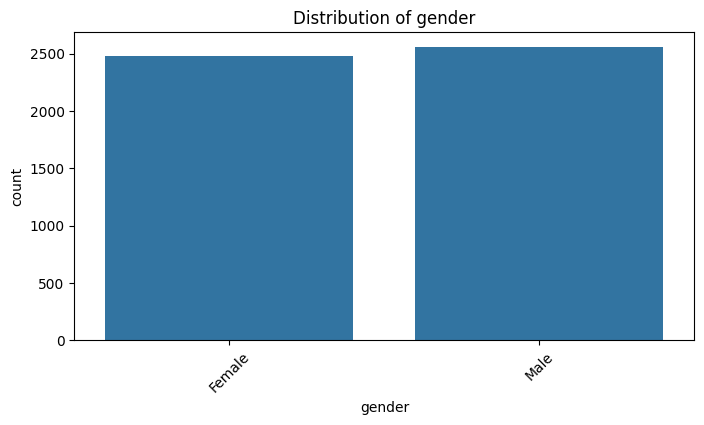

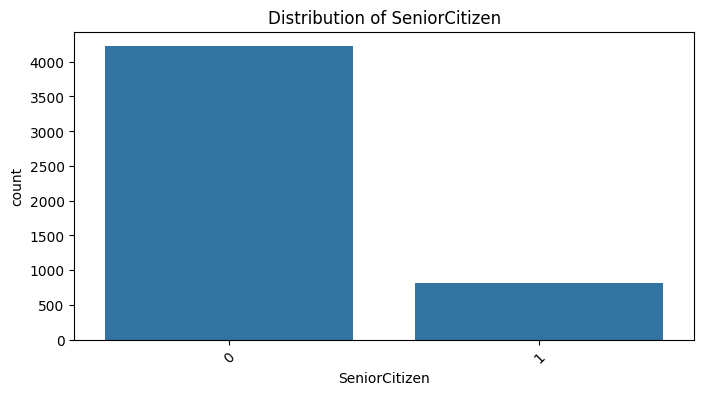

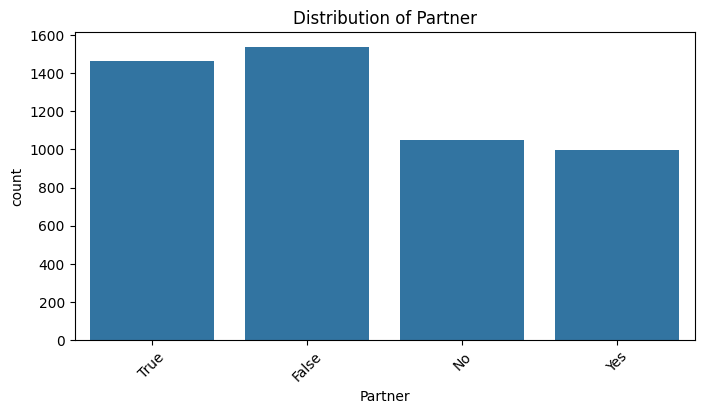

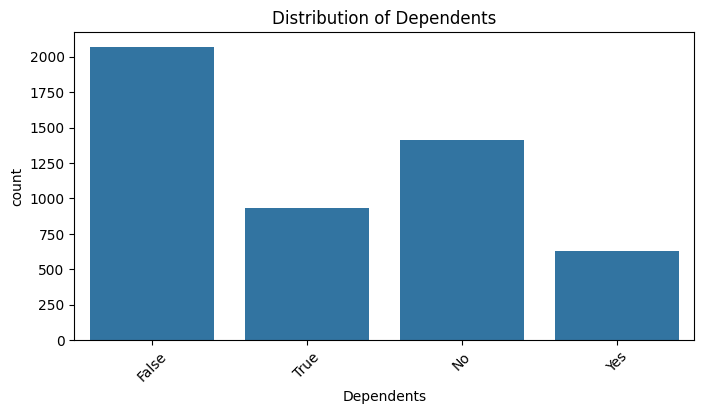

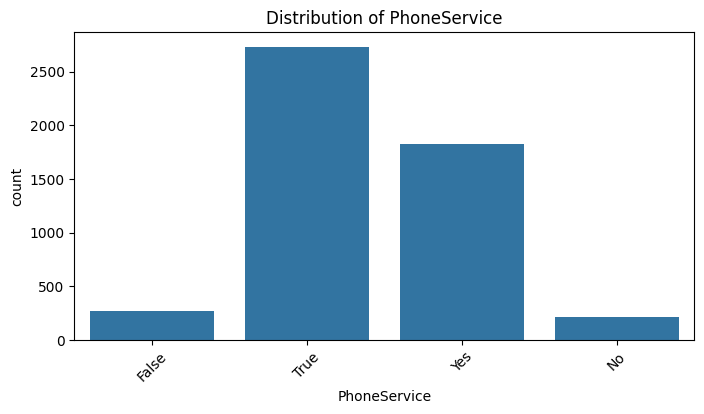

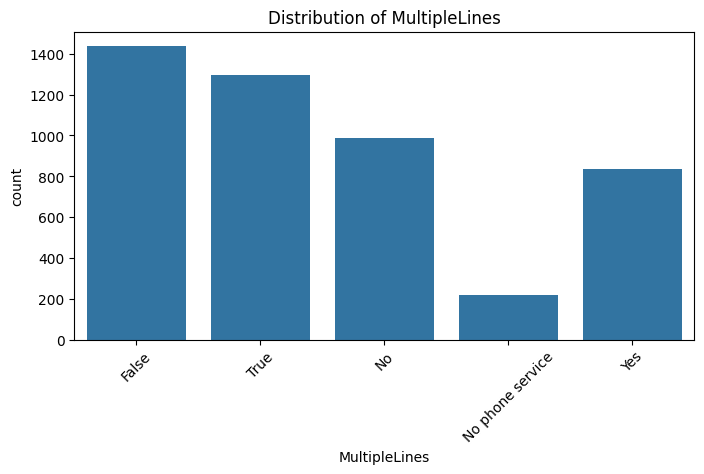

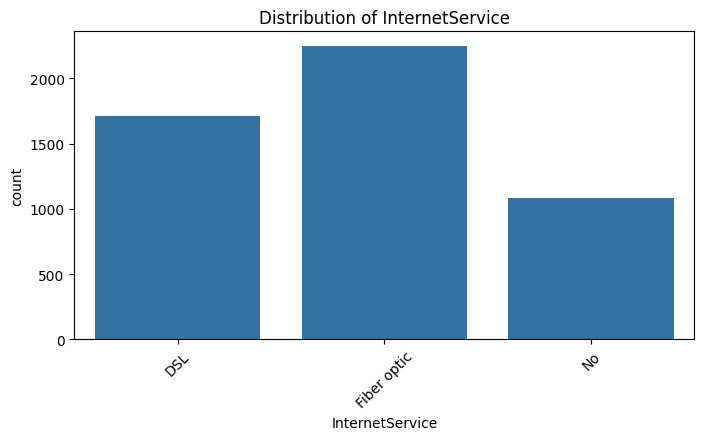

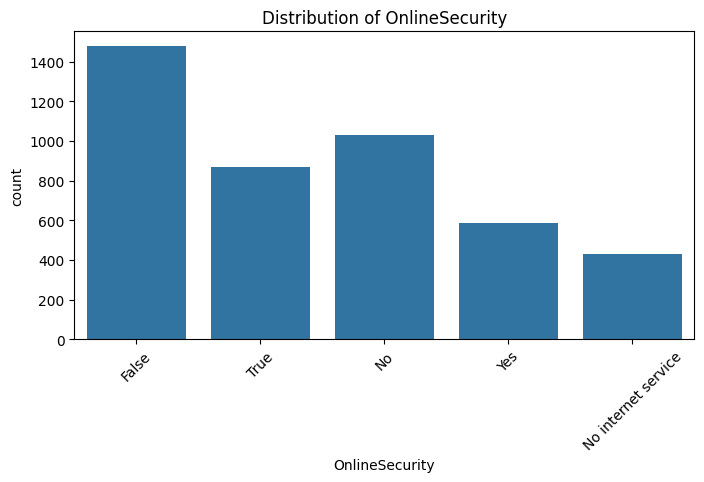

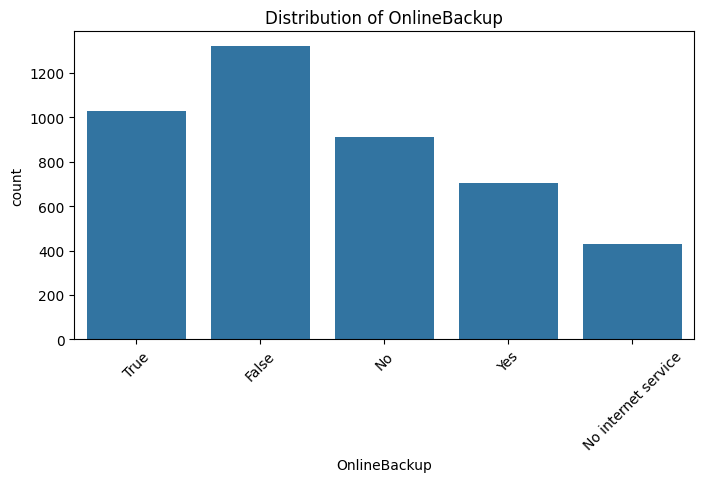

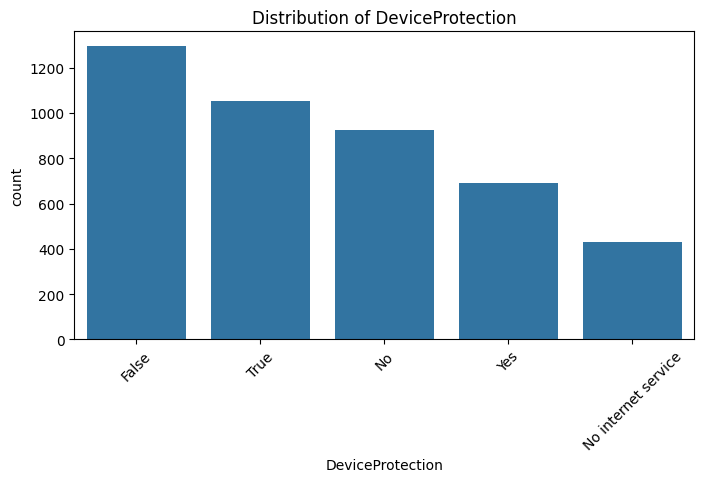

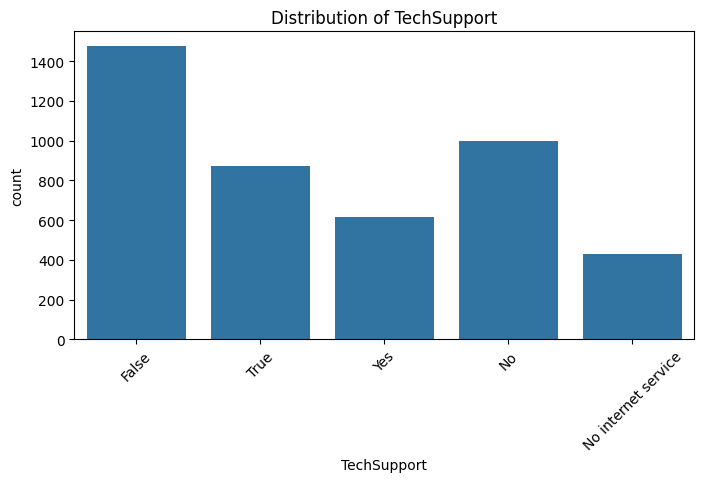

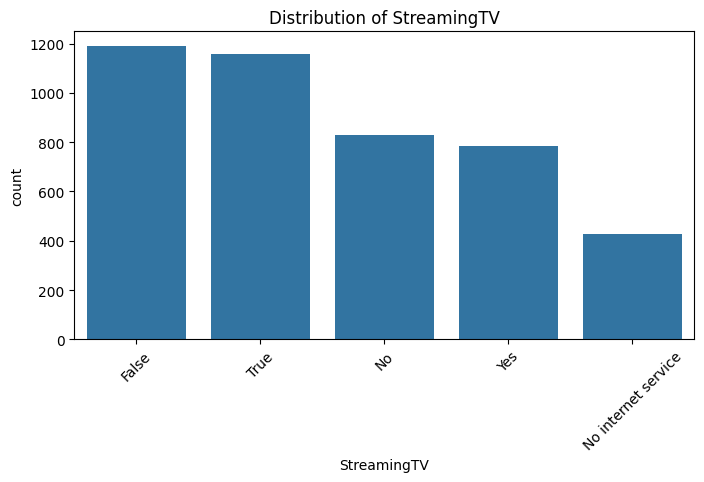

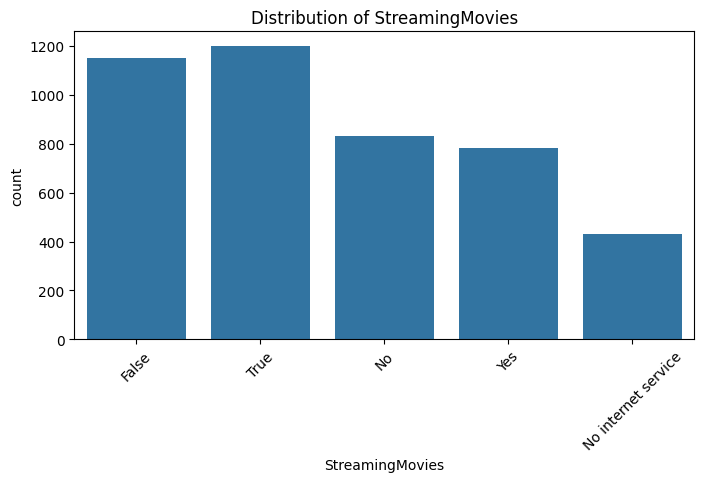

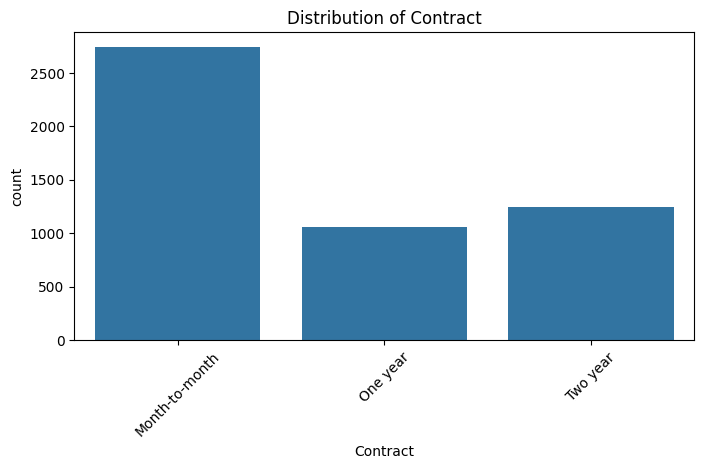

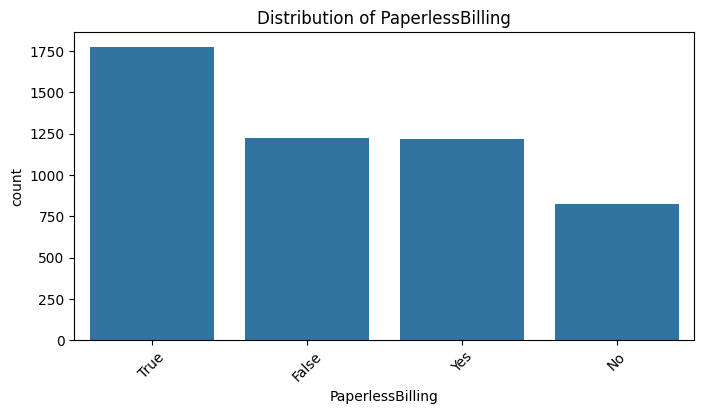

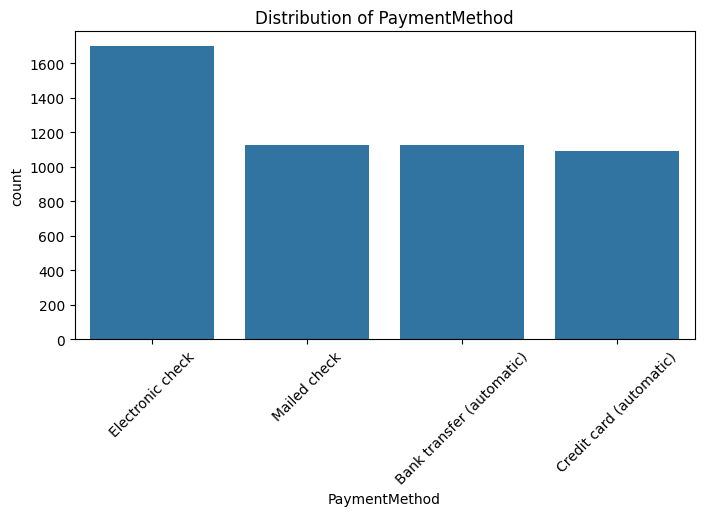

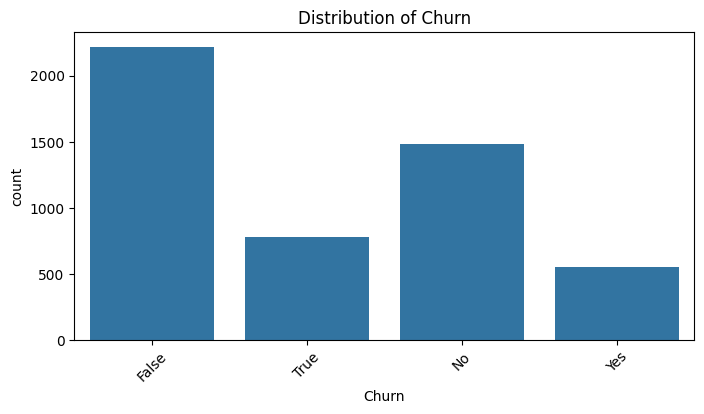

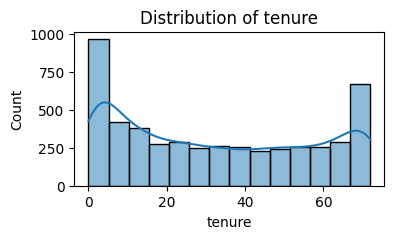

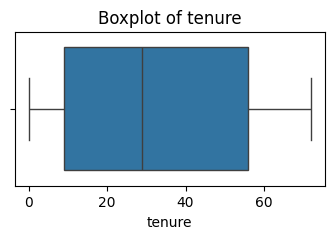

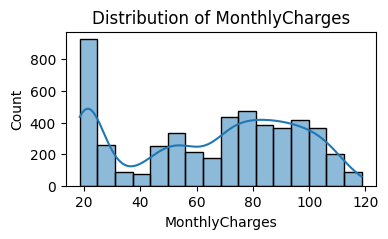

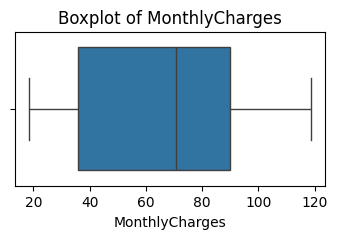

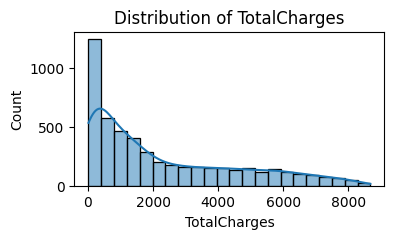

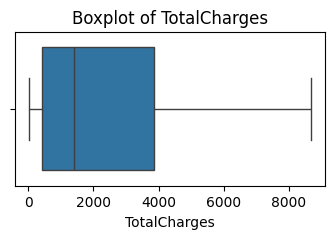

Missing Values:
 MultipleLines       269
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
TotalCharges          8
Churn                 1
dtype: int64


In [88]:
# Univariate analysis for Categorical Variables
categorical_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
                       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

for column in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=data_copy, x=column)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
    plt.show()

# Univariate analysis for Numerical Variables
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Convert 'TotalCharges' to numeric for analysis
data_copy['TotalCharges'] = pd.to_numeric(data_copy['TotalCharges'], errors='coerce')

for column in numerical_columns:
    plt.figure(figsize=(4, 2))
    sns.histplot(data_copy[column].dropna(), kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

    plt.figure(figsize=(4, 2))
    sns.boxplot(x=data_copy[column].dropna())
    plt.title(f'Boxplot of {column}')
    plt.show()

# Analysis for missing values
missing_values = data_copy.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])


#### Bivariate Analysis

Churn
False    1487
True      556
Name: count, dtype: int64


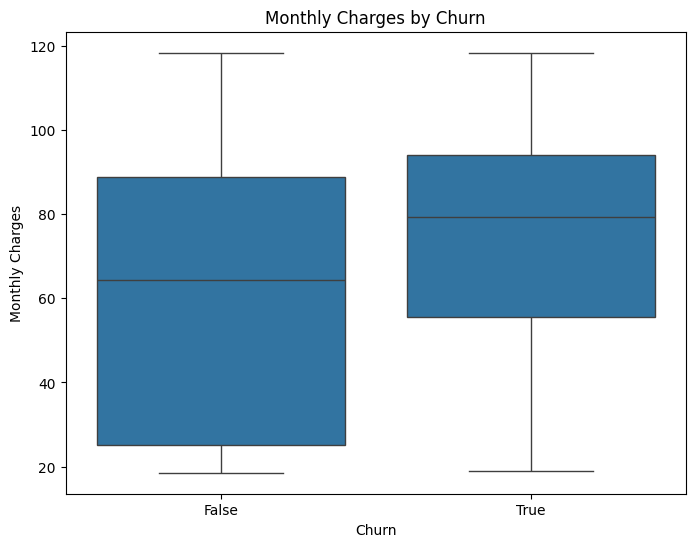

In [89]:
# Map 'Yes' to True and 'No' to False in the 'Churn' column
data_copy['Churn'] = data_copy['Churn'].map({'Yes': True, 'No': False, True: True, False: False})

# Verify that the mapping was successful
print(data_copy['Churn'].value_counts())

# Now, you can create the box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=data_copy, x='Churn', y='MonthlyCharges')
plt.title('Monthly Charges by Churn')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.show()

OBSERVATION

The plot reveals an inverse relationship between monthly charges and churn, indicating that customers with higher monthly charges are less likely to churn compared to those with lower charges.

A few potential reasons for this could be:

- Customers who pay more might perceive greater value in the service, making them less inclined to leave.
- Higher monthly fees might be linked to long-term contracts or bundled services that reduce the likelihood of short-term churn.
- Customers with higher payments may have made significant investments in setting up their service, making them less likely to switch due to the effort or expense involved.

#### Multivariate Analysis

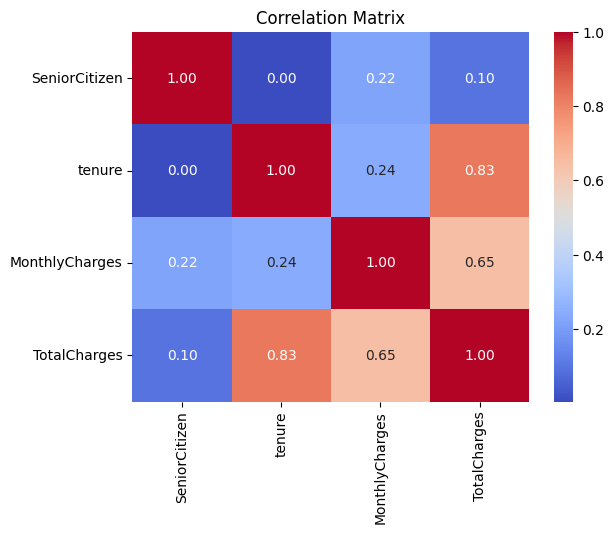

In [90]:
# Replace TotalCharges with MonthlyCharges where tenure is 0
data.loc[data['tenure'] == 0, 'TotalCharges'] = data.loc[data['tenure'] == 0, 'MonthlyCharges']

# Correlation matrix for numeric columns
numeric_columns = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
correlation_matrix = data[numeric_columns].corr()

# Heatmap of correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


### Answering Analytical Questions

#### 1. What payment methods do customers use the most?

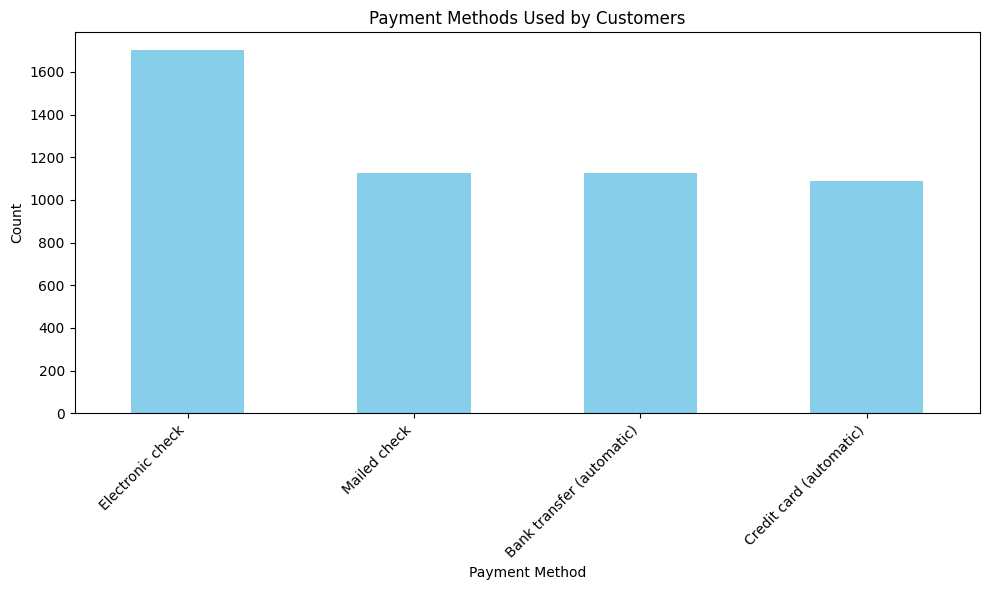

In [91]:
# Calculate the counts of each payment method
payment_counts = data['PaymentMethod'].value_counts()

plt.figure(figsize=(10, 6))
payment_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.title('Payment Methods Used by Customers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


OBSERVATION

It appears that the majority of customers prefer to use Electronic check as payment method followed by Mailed check then Bank transfer.

#### 2. What are the common payment methods among customers who churned?

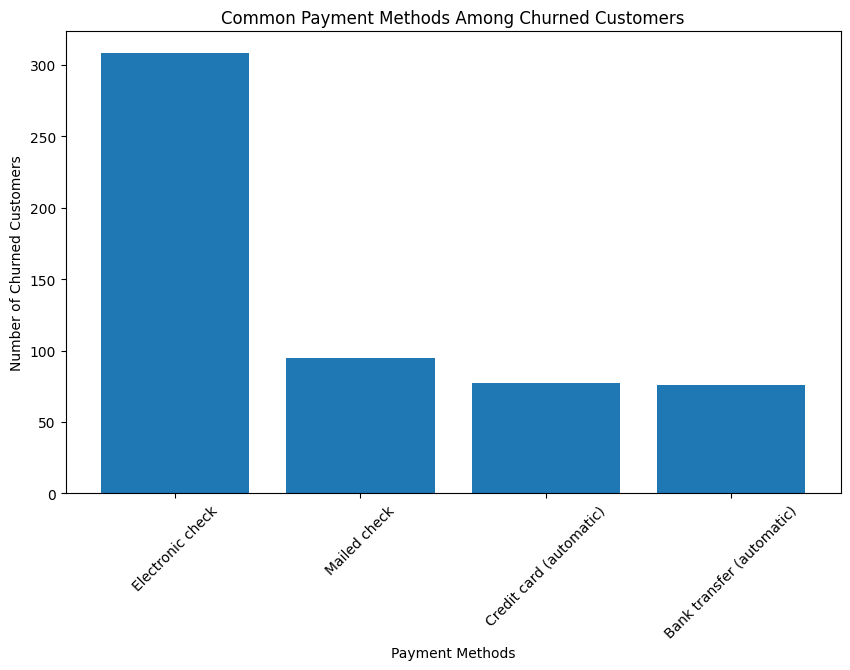

In [92]:
# Copy the data
m = data.copy()

# Make 'Yes' 'True' and 'No' 'False' in the 'Churn' column
m['Churn'] = m['Churn'].map({'Yes': True, 'No': False})

# Filter for churned customers
churned_customers = m[m['Churn'] == True]

# Count common payment methods among churned customers
common_payment_methods = churned_customers['PaymentMethod'].value_counts()

# Plot the common payment methods
plt.figure(figsize=(10, 6))
plt.bar(common_payment_methods.index, common_payment_methods.values)
plt.title('Common Payment Methods Among Churned Customers')
plt.xlabel('Payment Methods')
plt.ylabel('Number of Churned Customers')
plt.xticks(rotation=45)
plt.show()

OBSERVATION

From the chart above, the most common payment methods used by customers who churned are electronic check, mailed check, credit card and bank transfers.

#### 3. What proportion of customers are male and what proportion are female?

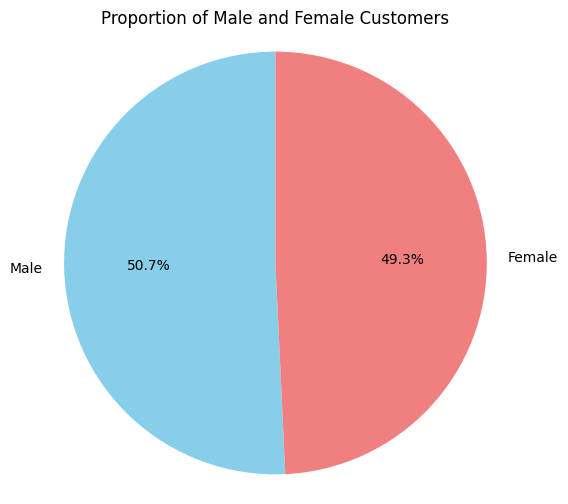

In [93]:
# Calculate the proportion of male and female customers
gender_counts = data['gender'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], startangle=90)
plt.title('Proportion of Male and Female Customers')
plt.axis('equal')
plt.show()


OBSERVATION

It is clear from the chart above that more customers are Male (50.7) compared to Female (49.3).

#### 4. Are customers with internet service more or less likely to churn compared to those without?

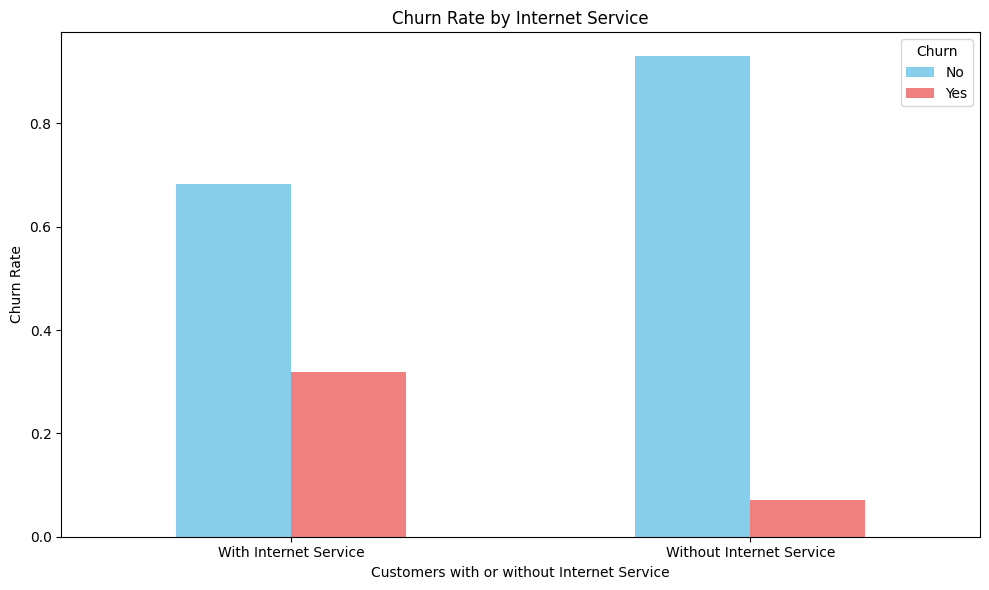

In [94]:
# Map values to 'No' and 'Others'
x = data
x['InternetService'] = x['InternetService'].replace({'No': 'Without Internet Service',
                                                 'DSL': 'With Internet Service',
                                                 'Fiber optic': 'With Internet Service'})

x['Churn'] = x['Churn'].replace({'True': 'Yes', 'False': 'No'})

# Calculate churn rates for 'No' and 'Others' categories
churn_rates = x.groupby('InternetService')['Churn'].value_counts(normalize=True).unstack()

churn_rates.plot(kind='bar', color=['skyblue', 'lightcoral'], figsize=(10, 6))
plt.xlabel('Customers with or without Internet Service')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Internet Service')
plt.xticks(rotation=0)
plt.legend(title='Churn', loc='upper right')
plt.tight_layout()
plt.show()


OBSERVATION

Customers With Internet Service are more likely to churn than customers Without Internet Service

#### 5. What is the distribution of churn outcomes among different genders?

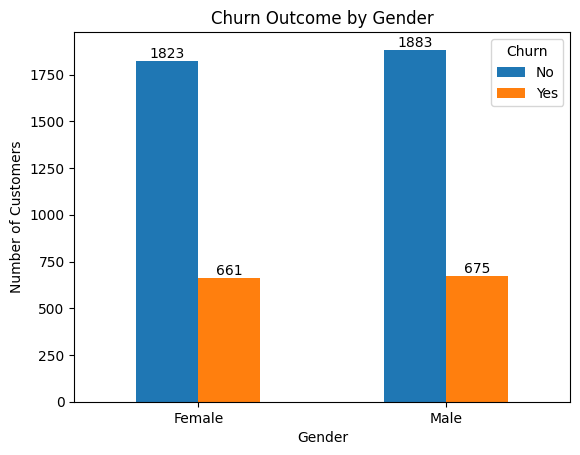

In [95]:
# Group the data by "gender" and "Churn" and count the number of customers
grouped_data = data.groupby(['gender', 'Churn']).size().unstack(fill_value=0)

# Plot the clustered column chart
ax = grouped_data.plot(kind='bar', stacked=False)
plt.title('Churn Outcome by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.legend(title='Churn', loc='upper right')
plt.xticks(rotation=0)

# Add data labels on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

OBSERVATION

The number of churned male customers (675) is slightly higher than churned female customers (661). However, both genders have a similar ratio of churned to non-churned customers, indicating that churn rates are relatively comparable across genders in this dataset.

### Hypothesis Testing

#### Null Hypothesis (H0): There is no significant difference in churn rates between different contract types.
#### Alternative Hypothesis (H1): There is significant difference in churn rates between different contract types.

ANOVA test results:
F-statistic: 12.588917643483857
P-value: 0.023839516160537245
Reject the null hypothesis: There is significant difference in churn rates between different contract types.


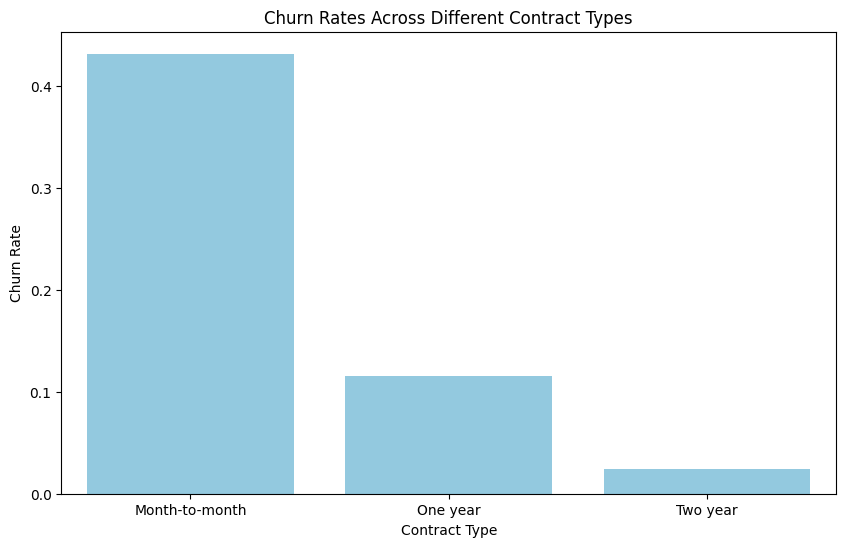

In [96]:
# Calculate churn rates by contract type
churn_rates = data.groupby('Contract')['Churn'].value_counts(normalize=True).unstack()

# Perform ANOVA
f_statistic, p_value = f_oneway(*[churn_rates[col] for col in churn_rates.columns])

# Set significance level (alpha)
alpha = 0.05

# Print ANOVA results
print("ANOVA test results:")
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

# Check for significance
if p_value < alpha:
    print("Reject the null hypothesis: There is significant difference in churn rates between different contract types.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in churn rates between different contract types.")

# Create barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=churn_rates.reset_index(), x='Contract', y='Yes', color='skyblue')
plt.xlabel('Contract Type')
plt.ylabel('Churn Rate')
plt.title('Churn Rates Across Different Contract Types')
plt.show()


#### `Conclusions`
- Based on the analysis and the ANOVA test results, we reject the null hypothesis, indicating a significant difference in churn rates between different contract types.

- The bar plot illustrates varying churn rates across contract types, with a notably higher churn rate observed among customers with a Month-to-Month contract.
- This finding suggests that contract terms significantly impact customer retention.
- To improve customer retention strategies, the marketing department should consider tailoring efforts to address the needs and preferences associated with different contract types.
- Specifically, for customers with a Month-to-Month contract, efforts should be made to encourage consideration of longer-term contracts, such as one year or two years.
- Targeted communication and incentives could be employed to promote long-term commitment and reduce churn within specific contract segments.

## `Data Preparation`

#### Check if Data is balanced

  Churn  TotalCount  Ratio
0    No        3706   73.5
1   Yes        1336   26.5


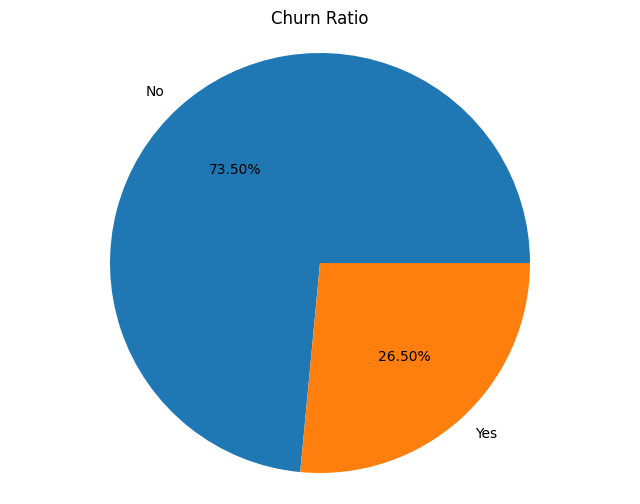

In [97]:
# Create copy of dataset
a = data.copy()

a['Churn'] = a['Churn'].replace({'True': 'Yes', 'False': 'No'})

churn_ratio = a['Churn'].value_counts().rename('TotalCount').reset_index()

churn_ratio['Ratio'] = ((churn_ratio['TotalCount'] / churn_ratio['TotalCount'].sum()) * 100).round(2)

print(churn_ratio)

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(churn_ratio['Ratio'], labels=churn_ratio['Churn'], autopct='%1.2f%%')
plt.title('Churn Ratio')
plt.axis('equal')
plt.show()

In [98]:
# Drop column that we don't need for our model
data.drop('customerID', axis=1, inplace=True)

# Dropping columns that we don't need
data.dropna(subset=['Churn'], inplace=True)



In [99]:
# Change empty string in TotalCharges to Null and change to a float
data['TotalCharges'] = data['TotalCharges'].replace(' ', np.nan).astype(float)

#### **Split Data into Train and Test**

- X = Input data
- y = Label

In [100]:
X = data.drop('Churn', axis=1)
y = data['Churn']

#### **Prepare Pipelines**

In [101]:
def log_transform(x):
    return np.log(x + 1)

In [102]:
log_transformer = FunctionTransformer(log_transform)

#### Split dataset in Categorical and Numeric columns

In [103]:
# Categorical columns
cat_columns = X.select_dtypes('object').columns
cat_columns

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [104]:
# Numeric Columns
num_columns = X.select_dtypes('number').columns
num_columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [105]:
# Define custom imputer to replace Null values in certain rows with 'No phone service' and 'No internet service'
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_no_phone='No phone service', columns_no_internet='No internet service'):
        self.columns_no_phone = columns_no_phone
        self.columns_no_internet = columns_no_internet
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        # Fill specified columns with 'No'
        X_copy[self.columns_no_phone] = X_copy[self.columns_no_phone].fillna('No phone service')
        # Fill specified columns with 'No phone'
        X_copy[self.columns_no_internet] = X_copy[self.columns_no_internet].fillna('No internet service')
        return X_copy


In [106]:
# Assign the column names to the respective variable names
custom_imputer = CustomImputer(columns_no_phone=['MultipleLines'], columns_no_internet=['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'])


In [107]:
# Define custom inputer to handle missing values in the TotalCharges column
class CustomImputer_1(BaseEstimator, TransformerMixin):
    def __init__(self, imputation_value=None):
        self.imputation_value = imputation_value
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        # Handle missing values in 'TotalCharges'
        if self.imputation_value is None:
            # Default imputation strategy: replace with 'MonthlyCharges' if 'tenure' is 0
            X_copy['TotalCharges'] = np.where(X_copy['tenure'] == 0, X_copy['MonthlyCharges'], X_copy['TotalCharges'])
        else:
            # Custom imputation value provided by the user
            X_copy['TotalCharges'].fillna(self.imputation_value, inplace=True)
        return X_copy

In [108]:
# Define the numeric pipeline
numeric_pipeline = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy = 'median')),
    ('log', FunctionTransformer(log_transform))
])

# Define the categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ('cat_impute', custom_imputer),
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
])

# Combine the numeric and categorical pipelines using ColumnTransformer
preprocesor = ColumnTransformer(transformers=[
    ('num_pipeline', numeric_pipeline, num_columns),
    ('cat_pipeline', categorical_pipeline, cat_columns)
])

In [109]:
y.value_counts()

Churn
No     3706
Yes    1336
Name: count, dtype: int64

In [110]:
# Initialize a LabelEncoder to encode the target variable
label_encoder = LabelEncoder()

# Encode the target variable using the LabelEncoder
y_resampled = label_encoder.fit_transform(y)
y_resampled

array([0, 0, 1, ..., 0, 1, 0])

In [111]:
# Split the dataset into training and testing sets, with 70% of the data used for training
X_train, X_test, y_train, y_test = train_test_split(X, y_resampled, train_size=0.7, random_state=42)

In [112]:
X_train

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1046,Female,0,False,False,52,True,True,With Internet Service,True,False,True,True,True,False,One year,False,Credit card (automatic),74.000000,3877.649902
2727,Male,0,False,False,5,True,True,With Internet Service,False,False,False,False,True,True,Month-to-month,True,Bank transfer (automatic),94.849998,462.799988
3140,Male,0,No,No,1,Yes,No,With Internet Service,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,89.250000,89.250000
30,Female,1,True,False,71,True,True,With Internet Service,True,True,True,True,False,False,Two year,True,Credit card (automatic),96.349998,6766.950195
725,Male,1,True,False,9,True,False,Without Internet Service,NaN,NaN,NaN,NaN,NaN,NaN,Month-to-month,True,Mailed check,21.250000,204.550003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4427,Male,0,No,No,41,Yes,No,Without Internet Service,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.150000,802.350000
466,Male,1,True,False,64,True,True,With Internet Service,False,False,True,True,True,True,Two year,False,Electronic check,102.099998,6538.450195
3093,Male,0,No,No,49,Yes,Yes,With Internet Service,No,No,No,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),66.150000,3199.000000
3773,Female,0,No,No,35,Yes,No,With Internet Service,Yes,Yes,Yes,No,No,No,Month-to-month,No,Electronic check,60.550000,1982.600000


## `Modeling`

In [113]:
# Define a list of tuples containing the names of the models to be evaluated
models = [
    ('Decision_Tree', DecisionTreeClassifier(random_state=42)),
    ('Logistic_Regression', LogisticRegression(random_state=42)),
    ('KNC', KNeighborsClassifier(n_neighbors=5)),
    ('Random_Forest', RandomForestClassifier(random_state=42))
]

metrics = []

# Iterate over each tuple to train the model, make predictions on the test set, and compute evaluation metrics
for model_name, model in models:
    final_pipeline = Pipeline(
        steps=[
            ('preprocesor',preprocesor),
            ('model',model)
        ]
    )
    
    final_pipeline.fit(X_train, y_train)
    y_pred = final_pipeline.predict(X_test)

    # Metrics such as accuracy, F1 score, ROC AUC score, precision, and recall are calculated for each model
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    pr = precision_score(y_test, y_pred)
    rc = recall_score(y_test, y_pred)

    metrics.append({'Model': model.__class__.__name__,
                    'Accuracy Score': acc,
                    'F1 Score': f1,
                    'ROC AUC Score': roc,
                    'Precision Score': pr,
                    'Recall Score': rc})

# Create a pandas DataFrame from the metrics and sort it based on the F1 score in descending order
overall = pd.DataFrame(metrics)
overall = overall.sort_values(by='F1 Score', ascending=False)
overall_styled = overall.style.background_gradient(cmap='winter')
overall_styled

,Model,Accuracy Score,F1 Score,ROC AUC Score,Precision Score,Recall Score
1,LogisticRegression,0.805023,0.610304,0.735236,0.631148,0.590793
3,RandomForestClassifier,0.799075,0.591398,0.722061,0.623229,0.562660
2,KNeighborsClassifier,0.764706,0.557214,0.702220,0.542373,0.572890
0,DecisionTreeClassifier,0.709848,0.492486,0.656068,0.449367,0.544757


In [114]:
# Define a list of classifier instances with specific configurations for each model
models = [DecisionTreeClassifier(random_state=42),
          LogisticRegression(random_state=42, n_jobs=-1),
          KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
          RandomForestClassifier(random_state=42, n_jobs=-1)]

# Iterate over each model to train the classifier, make predictions on the test set, and generate a classification report
for model in models:
    final_pipeline = Pipeline(
        steps=[
            ('preprocesor',preprocesor),
            ('models',model)
        ]
    )
    final_pipeline.fit(X_train, y_train)
    y_pred = final_pipeline.predict(X_test)

    # Display the classification report for each model, showing precision, recall, F1-score, and support for each class
    print("Model: ", model.__class__.__name__)
    print("Classification Report: \n", classification_report(y_test, y_pred))

    # Generate confusion matrices for each model using Plotly Express and display them
    # Each confusion matrix illustrates the counts of true positive, true negative, false positive,
    # and false negative predictions
    fig = px.imshow(confusion_matrix(y_test, y_pred), color_continuous_scale='twilight',
                    title = "Confusion Matrix of " + model.__class__.__name__,
                    labels = dict(x="Predicted", y="Actual", color="Counts"),
                    color_continuous_midpoint=0.8, width=400, height=400,
                    template="plotly_dark", text_auto=True)
    
    fig.show()

    print("----------------------------------------------------------")

Model:  DecisionTreeClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.77      0.80      1122
           1       0.45      0.54      0.49       391

    accuracy                           0.71      1513
   macro avg       0.64      0.66      0.64      1513
weighted avg       0.73      0.71      0.72      1513



----------------------------------------------------------
Model:  LogisticRegression
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.88      0.87      1122
           1       0.63      0.59      0.61       391

    accuracy                           0.81      1513
   macro avg       0.75      0.74      0.74      1513
weighted avg       0.80      0.81      0.80      1513



----------------------------------------------------------
Model:  KNeighborsClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      1122
           1       0.54      0.57      0.56       391

    accuracy                           0.76      1513
   macro avg       0.70      0.70      0.70      1513
weighted avg       0.77      0.76      0.77      1513



----------------------------------------------------------
Model:  RandomForestClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.88      0.87      1122
           1       0.62      0.56      0.59       391

    accuracy                           0.80      1513
   macro avg       0.74      0.72      0.73      1513
weighted avg       0.79      0.80      0.80      1513



----------------------------------------------------------


#### Training On A Balanced Data

In [116]:
all_balanced_pipelines = {}

# define table to hold all the metrics
balanced_metrics_table = pd.DataFrame(columns=['model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'conf_matrix'])

# loop through the models
for model in models:
# build final pipeline with preprocessor estimator
    balanced_pipeline = ImbPipeline(steps=[
        ('preprocessor',preprocesor),
        ('smote-sampler',SMOTE(random_state=42)),
        ('estimator', model)
    ])

    # fit training data to final pipeline
    balanced_pipeline.fit(X_train, y_train)

    # add models to all_pipeline dictionary
    all_balanced_pipelines[model] = balanced_pipeline

    # make prediction
    y_predict = balanced_pipeline.predict(X_test)

    # Generate Classification report for each pipeline or model
    balanced_metrics = classification_report(y_test, y_predict, output_dict=True)
        
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_predict)

    # Grab all important metrics
    accuracy = balanced_metrics['accuracy']
    precision = balanced_metrics['weighted avg']['precision']
    recall = balanced_metrics['weighted avg']['recall']
    f1_score = balanced_metrics['weighted avg']['f1-score']

    # add important metrics to metrics_table
    balanced_metrics_table.loc[len(balanced_metrics_table)] = [model.__class__.__name__, accuracy, precision, recall, f1_score, conf_matrix]

# display metrics_table
# balanced_metrics_table = balanced_metrics_table.style.background_gradient(cmap='winter')
balanced_metrics_table.sort_values(by="accuracy", ascending=False)

,model_name,accuracy,precision,recall,f1_score,conf_matrix
3,RandomForestClassifier,0.777264,0.782915,0.777264,0.779788,"[[939, 183], [154, 237]]"
1,LogisticRegression,0.738929,0.811559,0.738929,0.754374,"[[795, 327], [68, 323]]"
0,DecisionTreeClassifier,0.705221,0.724411,0.705221,0.713110,"[[861, 261], [185, 206]]"
2,KNeighborsClassifier,0.678123,0.772650,0.678123,0.698023,"[[723, 399], [88, 303]]"


#### Hyperparameter Tuning

In [117]:
# Define the models
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
log_reg = LogisticRegression(random_state=42, n_jobs=-1)


# Define parameter grid for the three models
params_grid = {
    'rfc': {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__bootstrap': [True, False]
    },
    'log_reg': {
    'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'model__max_iter': [100, 200, 300]
    }
}


# Initialize dictionary to store best params and best model
best_models = {}
best_params = {}



# Perform grid search for each model
for model_name, params in params_grid.items():
    if model_name == "rfc":
        model = rfc
    else:
        model = log_reg
        
    balanced_pipeline = ImbPipeline(steps=[
    ('preprocessor',preprocesor),
    ('smote-sampler',SMOTE(random_state=42)),
    ('model', model )
    ])   
    grid_cv = GridSearchCV(estimator=balanced_pipeline,param_grid=params, scoring='f1', n_jobs=-1, verbose=2)

    grid_cv.fit(X_train, y_train)

    # Get best params and best model
    best_params[model_name] = grid_cv.best_params_
    best_models[model_name] = grid_cv.best_estimator_

# Print best parameters for each model
for model_name, params in best_params.items():
    print(f"The best parameters for {model_name}: {params}")

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
The best parameters for rfc: {'model__bootstrap': True, 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 300}
The best parameters for log_reg: {'model__C': 1, 'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'saga'}


In [118]:
best_models


{'rfc': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('num_pipeline',
                                                   Pipeline(steps=[('num_imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('log',
                                                                    FunctionTransformer(func=<function log_transform at 0x000001CC86611750>))]),
                                                   Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                  ('cat_pipeline',
                                                   Pipeline(steps=[('cat_imput...
        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
        'PaperlessBilling', 'PaymentMethod'],
   

#### Persist Model

In [119]:
# Grab the Random Forest pipeline
forest_pipeline = best_models["rfc"]

# Grab the K Nearest Neighbours pipeline
log_reg_pipeline = best_models["log_reg"]

# Grab the encoder
encoder = LabelEncoder()

In [120]:
with open("trained_models/forest_pipeline.joblib","wb") as file:
    joblib.dump(forest_pipeline, file)

In [121]:
with open("trained_models/log_reg_pipeline.joblib","wb") as file:
    joblib.dump(log_reg_pipeline, file)

In [122]:
with open("trained_models/encoder.joblib","wb") as file:
    joblib.dump(encoder, file)